In [1]:
import pandas as pd
import random, math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import fftpack
import torch.utils.data as utils
import os
from sklearn.metrics import mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
# !gdown 'https://drive.google.com/uc?id=1E_qqe7kfvfApM4hCOBMPoXhyEPyrUJkN'
# !gdown 'https://drive.google.com/uc?id=1j-3-lHegY--FDHKZvz86HBtilV2dsP-i'

In [ ]:
# !unzip 'train.zip' -d '.'
# !unzip 'test.zip' -d '.'

In [58]:
class TrafficForecast(Dataset):
    def __init__(self,pkl_path, window, horizon, task='train'):
        self.pkl_path = pkl_path
        self.window = window
        self.horizon = horizon
        self.df = None
        self.seg_ids = None
        self.X = []
        self.y = []


        df = pd.read_pickle(self.pkl_path)
        df['time'] = pd.to_datetime(df['time'])
        df['unix_timestamp'] = df['time'].astype(int) / 10**9
        df['dow'] = df['time'].dt.weekday
        df['hour'] = df['time'].dt.hour
        df['min'] = df['time'].dt.minute
        self.df = df
        # self.df = df.sample(frac=1).reset_index(drop=True)
        self.seg_ids = self.df['segmentID'].unique()
        self.setup_forecast()
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=1)
     

        if task == 'train':
            self.inputs = X_train
            self.targets = y_train
        if task == 'test':
            self.inputs = X_test
            self.targets = y_test


    def setup_forecast(self):
        for segid in self.seg_ids:
            df_seg_id = self.df[self.df['segmentID'] == segid]
            df_seg_id = df_seg_id.sort_values(by='time',ascending=True)
            df_seg_id = df_seg_id.fillna(method="ffill")
            TI_series = df_seg_id['TrafficIndex_GP'].values
            hour_series = df_seg_id['hour'].values
            #split to train and test
            for t in range(0,len(TI_series)-(self.window+self.horizon)):
                # x = np.vstack((TI_series[t:t+self.window], hour_series[t:t+self.window]))
                x = TI_series[t:t+self.window]
                y = TI_series[t+self.window:(t+self.window+self.horizon)]

                self.X.append(x)
                self.y.append(y)

    def __len__(self):
        return len(self.inputs)


    def __getitem__(self,idx):
        X = torch.tensor(self.inputs[idx],dtype=torch.float32).reshape(self.window,1)
        y=torch.tensor(self.targets[idx],dtype=torch.float32)

        return {'inputs':X,'outputs':y}


In [59]:
tobj_train = TrafficForecast('tps_df.pkl',10,36,"train")
tobj_test = TrafficForecast('tps_df.pkl',10,36,"test")

/tmp/ipykernel_69455/3497787159.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_seg_id = df_seg_id.fillna(method="ffill")
/tmp/ipykernel_69455/3497787159.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_seg_id = df_seg_id.fillna(method="ffill")


In [60]:
bs = 1024
dataloader_train = DataLoader(tobj_train, batch_size=bs, shuffle=False, num_workers=0,drop_last=True)
dataloader_test = DataLoader(tobj_test, batch_size=bs, shuffle=False, num_workers=0,drop_last=True)

In [61]:
for idx, data in enumerate(dataloader_train):
    print (idx, data['inputs'].shape,data['outputs'].shape)
    if idx == 3:
        break
print("#####")
for idx, data in enumerate(dataloader_test):
    print (data['inputs'].shape,data['outputs'].shape)
    if idx == 3:
        break

0 torch.Size([1024, 10, 1]) torch.Size([1024, 36])
1 torch.Size([1024, 10, 1]) torch.Size([1024, 36])
2 torch.Size([1024, 10, 1]) torch.Size([1024, 36])
3 torch.Size([1024, 10, 1]) torch.Size([1024, 36])
#####
torch.Size([1024, 10, 1]) torch.Size([1024, 36])
torch.Size([1024, 10, 1]) torch.Size([1024, 36])
torch.Size([1024, 10, 1]) torch.Size([1024, 36])
torch.Size([1024, 10, 1]) torch.Size([1024, 36])


In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [62]:
from models import MyLSTM, MyGRU

In [64]:
model = MyGRU(n_inputs=1, n_hidden=10, n_rnnlayers=2, n_outputs=36)
# model = MyLSTM(n_inputs=1, n_hidden=10, n_rnnlayers=2, n_outputs=36)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [65]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 3
# ts = ToTensor()
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs = model(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  mean_loss.append(np.mean(losses))
  mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')

  0%|          | 0/3 [00:00<?, ?it/s]/home/tanner/miniconda3/envs/sam/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tanner/miniconda3/envs/sam/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 1/3 [00:09<00:19,  9.53s/it]

Epoch 1/3, Training Loss: 0.0781


 67%|██████▋   | 2/3 [00:19<00:09,  9.67s/it]

Epoch 2/3, Training Loss: 0.0445


100%|██████████| 3/3 [00:29<00:00,  9.74s/it]

Epoch 3/3, Training Loss: 0.0330


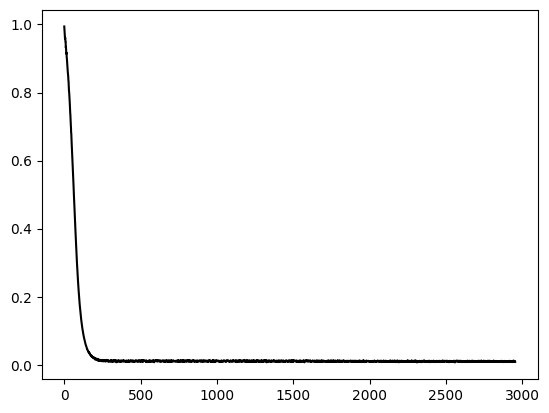

In [66]:
plt.plot(losses,'k',label='training')


In [39]:
torch.save(model.state_dict(), 'model_volume.pt')
# torch.save(model.state_dict(), 'model_volumehour.pt')

In [69]:
# model_volumehour = MyGRU(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=36)
# model_volumehour.load_state_dict(torch.load('model_volumehour.pt'))
# model_volume = MyGRU(n_inputs=1, n_hidden=10, n_rnnlayers=2, n_outputs=36)
# model_volume.load_state_dict(torch.load('model_volume.pt'))
# model_volumehour.eval()
model.eval()

MyGRU(
  (relu): ReLU()
  (rnn): GRU(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=36, bias=True)
)

In [67]:
def evaluation(model_arch,dataloader_test):
    model_arch.to(device)
    rmse = []
    maes = []
    for i_test,sample_test in enumerate(dataloader_test):
        preds = model_arch(sample_test['inputs'].to(device))
        targets = sample_test['outputs'].to(device)
        error = ((preds-targets)**2).sum(1).mean().detach().cpu().numpy()
        mae = (preds-targets).abs().sum(1).mean().detach().cpu().numpy()
        rmse.append(math.sqrt(error))
        maes.append(mae)
    return {'rmse':np.mean(rmse),'mae':np.mean(maes)}

In [24]:
##add hour dimension to training
eval_volhour = evaluation(model, dataloader_test)
print(f"Volume and Hour dimension. rmse: {eval_volhour['rmse']}, mae: {eval_volhour['mae']}")



Volume and Hour dimension. rmse: 0.6048032276825978, mae: 1.7566388845443726


In [43]:
eval_vol = evaluation(model, dataloader_test)
print(f"Only volume dimension. rmse: {eval_vol['rmse']} mae: {eval_vol['mae']}")

Only volume dimension. rmse: 0.6287271059886029 mae: 1.8069144487380981


In [44]:
##compare the lstm to GRU: window = 10,36, horizon 36
eval = evaluation(model, dataloader_test)
print(f"GRU window 36, horizon 36 on volume only. rmse: {eval['rmse']} mae: {eval['mae']}")

GRU window 36, horizon 36 on volume only. rmse: 0.6287271059886029 mae: 1.8069144487380981


In [70]:
eval = evaluation(model, dataloader_test)
print(f"GRU window 10, horizon 36 on volume only. rmse: {eval['rmse']} mae: {eval['mae']}")

GRU window 10, horizon 36 on volume only. rmse: 0.5985679901957417 mae: 1.6180999279022217


In [48]:
eval = evaluation(model, dataloader_test)
print(f"LSTM window 36, horizon 36 on volume only. rmse: {eval['rmse']} mae: {eval['mae']}")

LSTM window 36, horizon 36 on volume only. rmse: 0.5858976564886356 mae: 1.5746110677719116


In [57]:
eval = evaluation(model, dataloader_test)
print(f"LSTM window 10, horizon 36 on volume only. rmse: {eval['rmse']} mae: {eval['mae']}")

LSTM window 10, horizon 36 on volume only. rmse: 0.585550403201656 mae: 1.4473798274993896
